# Imports

In [1]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


# Hyperparameters

In [2]:
batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 20
epsilon_std = 1.0

# Autoencoder layers

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

# Decoder layers

In [5]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")

# Combining models

In [6]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Loss function

In [7]:
def vae_loss(x, x_decoded_mean, z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

#vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop', loss=vae_loss)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Train/test split

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Train

In [9]:
vae.fit(x_train, x_train, shuffle=True,
       nb_epoch=nb_epoch,
       batch_size=batch_size,
       validation_data=(x_test, x_test), verbose=1)

/home/stelling/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 156us/step - loss: 191.5365 - val_loss: 174.2493
Epoch 2/20
60000/60000 [==============================] - 9s 150us/step - loss: 171.8713 - val_loss: 169.3278
Epoch 3/20
60000/60000 [==============================] - 9s 150us/step - loss: 168.2929 - val_loss: 166.3682
Epoch 4/20
60000/60000 [==============================] - 10s 162us/step - loss: 165.7548 - val_loss: 164.7309
Epoch 5/20
60000/60000 [==============================] - 10s 161us/step - loss: 164.0593 - val_loss: 163.8344
Epoch 6/20
60000/60000 [==============================] - 9s 157us/step - loss: 162.8779 - val_loss: 162.4317
Epoch 7/20
60000/60000 [==============================] - 9s 156us/step - loss: 161.9314 - val_loss: 162.0214
Epoch 8/20
60000/60000 [==============================] - 10s 168us/step - loss: 161.1880 - val_loss: 161.1027
Epoch 9/20
60000/60000 [==============================] - 10s 168us

# Digit classes in latent space

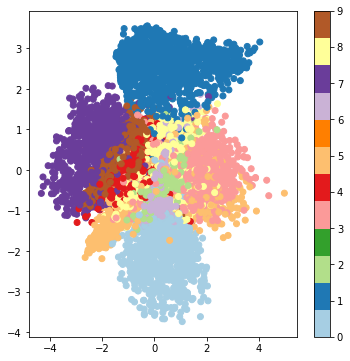

In [10]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='Paired')
plt.colorbar()
plt.show()

# Generate digits

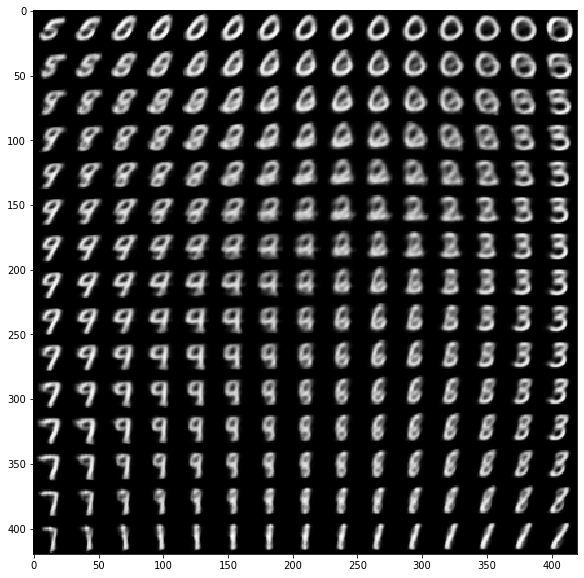

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()